In [1]:
!pip install scikit-fmm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfmm
from queue import PriorityQueue

In [3]:
# Parameters
N = 101              # Grid size (NxN)
h = 0.1              # Grid spacing
tol = 1e-6           # Tolerance for stopping criterion
infinity = 10 * (N * h) ** 2  # Large value

In [4]:
# Spatially varying speed F(x, y)
x = np.linspace(0, N * h, N)
y = np.linspace(0, N * h, N)
X, Y = np.meshgrid(x, y)
#F = 1 + 0.5 * (X / (N * h))  # Speed varies from 1 to 1.5 across the field

# --- Seismic waves case
#F = 1.5 - 0.4 * (Y / (N * h)) + 0.2 * np.exp(-((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 0.02)
# --- Wind ocean currents
#F = 1 + 0.5 * np.sin(X * 2 * np.pi / (N * h)) * np.exp(-Y / (N * h))
# --- Medical imaging
#F = 1.4 + (X > 0.3 * N * h) * (X < 0.7 * N * h) * 0.2 + (Y > 0.6 * N * h) * 0.9
# --- Hydrology
#F = 1.0 + 0.5 * np.exp(-((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 0.1)
# --- Urban navigation
#F = 1 + 0.3 * (np.sin(X * np.pi / (N * h)) + np.cos(Y * np.pi / (N * h)))
# --- Semiconductor materials
#F = 1 + 0.5 * np.exp(-(Y / (N * h))**2) * np.cos(X * 2 * np.pi / (N * h))
# --- Propagation through forests
F = 1.2 - 0.3 * np.exp(-((X - 0.5) ** 2 + (Y - 0.5) ** 2) / 0.05)

In [5]:
# Source points
source = np.array([
    [21, 21],
    [71, 71]
])

# Initialize phi (distance field): 0 at source points, 1 elsewhere
phi = np.ones((N, N))
for sx, sy in source:
    phi[int(sx), int(sy)] = 0  # Ensure indices are integers

In [6]:
# Fast Marching Method with scikit-fmm
u_skfmm = skfmm.travel_time(phi, order=1, speed=F, dx=h)

In [7]:
# Separate Eikonal update function
def update_eikonal_2D(i, j, u, F, h, N):
    # Calculate minimum neighboring values
    if i == 0:
        a = u[i + 1, j]
    elif i == N - 1:
        a = u[i - 1, j]
    else:
        a = min(u[i + 1, j], u[i - 1, j])

    if j == 0:
        b = u[i, j + 1]
    elif j == N - 1:
        b = u[i, j - 1]
    else:
        b = min(u[i, j + 1], u[i, j - 1])

    # Eikonal equation update
    if abs(a - b) < h * F[i, j]:
        u_new = 0.5 * (a + b + np.sqrt((2 * (h * F[i, j]) ** 2) - (a - b) ** 2))
    else:
        u_new = h * F[i, j] + min(a, b)

    return min(u[i, j], u_new)

In [8]:
# Custom Fast Marching Method function
def custom_fast_marching(N, F, source, h, tol, infinity):
    u = np.full((N, N), infinity)         # Eikonal initialization
    isSet = np.full((N, N), False)        # Mask for already set nodes
    activeList = PriorityQueue()          # Priority queue for active nodes

    # Set source points and initialize the queue
    for sx, sy in source:
        u[int(sx), int(sy)] = 0
        activeList.put((0, int(sx), int(sy)))

    # Fast Marching iterations
    while not activeList.empty():
        u_val, i, j = activeList.get()
        isSet[i, j] = True

        # Neighbors
        neighbors = [(i, j - 1), (i, j + 1), (i - 1, j), (i + 1, j)]

        for ni, nj in neighbors:
            if 0 <= ni < N and 0 <= nj < N and not isSet[ni, nj]:
                updated_val = update_eikonal_2D(ni, nj, u, F, h, N)

                # Check if neighbor is already in queue with the same value
                if updated_val < u[ni, nj]:
                    u[ni, nj] = updated_val
                    activeList.put((updated_val, ni, nj))

    return u

In [9]:
# Call the custom Fast Marching Method
u_custom = custom_fast_marching(N, 1 / F, source, h, tol, infinity)

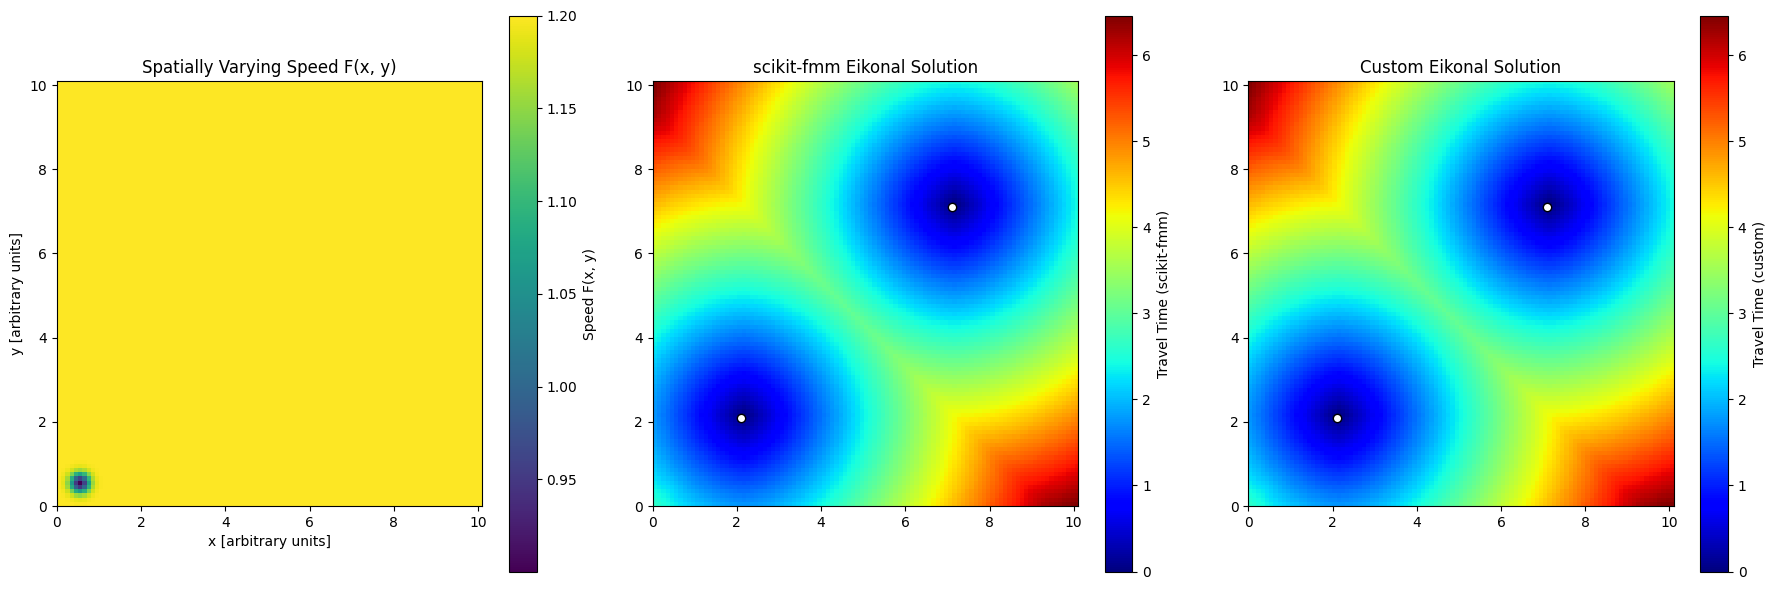

Root Mean Square Error between scikit-fmm and custom solution: 0.0000%


In [10]:
# Plotting the results
x = np.arange(0, N) * h
y = np.arange(0, N) * h
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Speed field
c0 = ax[0].imshow(F, extent=(0, N * h, 0, N * h), origin='lower', cmap='viridis')
fig.colorbar(c0, ax=ax[0], label='Speed F(x, y)')
ax[0].set_title('Spatially Varying Speed F(x, y)')
ax[0].set_xlabel('x [arbitrary units]')
ax[0].set_ylabel('y [arbitrary units]')

# skfmm solution
c1 = ax[1].imshow(u_skfmm, extent=(0, N * h, 0, N * h), origin='lower', cmap='jet')
fig.colorbar(c1, ax=ax[1], label='Travel Time (scikit-fmm)')
ax[1].set_title('scikit-fmm Eikonal Solution')
ax[1].scatter(source[:, 0] * h, source[:, 1] * h, color='white', edgecolors='black', marker='o')

# Custom solution
c2 = ax[2].imshow(u_custom, extent=(0, N * h, 0, N * h), origin='lower', cmap='jet')
fig.colorbar(c2, ax=ax[2], label='Travel Time (custom)')
ax[2].set_title('Custom Eikonal Solution')
ax[2].scatter(source[:, 0] * h, source[:, 1] * h, color='white', edgecolors='black', marker='o')

plt.tight_layout()
plt.show()

# Error calculation
error = 100 * np.sqrt(np.sum((u_skfmm - u_custom)**2) / np.sum(u_skfmm**2))
print(f"Root Mean Square Error between scikit-fmm and custom solution: {error:.4f}%")
